# Training a model using Pytorch
I am practicing using pytorch in this notebook following the steps in this tutorial: 

https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html


## Import things

In [1]:
import os
import cv2
import numpy as np
import pandas as pd

import tifffile as tiff
from PIL import Image, ImageDraw
from torchvision.transforms import ToPILImage  

import pycocotools

import torch
import torchvision
import torch.utils.data

from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

import utils
import transforms as T
from engine import train_one_epoch, evaluate

In [2]:
image_path = '../train/images/slices/'
images = os.listdir(image_path)

data_path = '../CSVs'
datafiles = os.listdir(data_path)

### Some functions

In [3]:
# this function turns the dataframe of coordinates into arrays

def parse_one_annot(path_to_data_file, filename):
    data = pd.read_csv(path_to_data_file)
    boxes_array = data[data["filename"] == filename][["xmin", "ymin",        
    "xmax", "ymax"]].values
   
    return boxes_array

In [4]:
### This model just gives you a bounding box

def get_model(num_classes):
    # load an object detection model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    
    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    
    # replace the pre-trained head with a new on
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
   
    return model

In [5]:
## This model will give you bounding boxes and masks

def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [6]:
# This function converts an image into a PyTorch Tensor
# and flips the image horizontally sometimes during training

def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
      # during training, randomly flip the training images
      # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

### Make a Glomeruli class 

In [7]:
class GlomeruliDataset(torch.utils.data.Dataset):
    def __init__(self, root, data_file, transforms=None):
        self.root = root
        self.transforms = transforms
        self.imgs = sorted(os.listdir(os.path.join(root, 'train/images/slices')))
        self.path_to_data_file = data_file
        self.masks = sorted(os.listdir(os.path.join(root, 'train/masks/slices')))
        
    def __getitem__(self, idx):
        # load images and bounding boxes
        img_path = os.path.join(self.root,'train/images/slices', self.imgs[idx])
        mask_path = os.path.join(self.root, 'train/masks/slices', self.masks[idx])

        img = tiff.imread(img_path)
        if len(img.shape) == 5:
            img = img.squeeze().transpose(1, 2, 0)
                    
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        
        mask = tiff.imread(mask_path)
        mask = np.array(mask)
        
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]
        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]
        
        #boxes
        box_list = parse_one_annot(self.path_to_data_file, self.imgs[idx])
        boxes = torch.as_tensor(box_list, dtype=torch.float32)
        num_objs = len(box_list)
        masks = torch.as_tensor(masks)

        
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:,0])
        
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["masks"] = masks
        target["iscrowd"] = iscrowd
        if self.transforms is not None:
            img, target = self.transforms(img, target)
        return img, target
    
    def __len__(self):
        return len(self.imgs)

In [8]:
# Try out the class and see what it gives you:
dataset = GlomeruliDataset(root = r'C:\Users\lettuces\Documents\Projects\hubmap-kidney-segmentation', 
                           data_file = '../CSVs/glomeruli_tiles.csv')
dataset.__getitem__(1)

(array([[191, 200, 217, ..., 214, 214, 214],
        [206, 148, 180, ..., 215, 215, 216],
        [197, 139, 151, ..., 217, 214, 173],
        ...,
        [216, 217, 216, ..., 219, 218, 218],
        [218, 215, 216, ..., 221, 220, 217],
        [216, 215, 216, ..., 218, 218, 218]], dtype=uint8),
 {'boxes': tensor([[ 278.,  778.,  409.,  805.],
          [ 918.,  611., 1067.,  698.],
          [ 221.,  354.,  383.,  515.],
          [ 159.,  134.,  277.,  240.],
          [   0.,    0.,   83.,   57.]]),
  'labels': tensor([1, 1, 1, 1, 1]),
  'image_id': tensor([1]),
  'area': tensor([ 3537., 12963., 26082., 12508.,  4731.]),
  'masks': tensor([[[False, False, False,  ..., False, False, False],
           [False, False, False,  ..., False, False, False],
           [False, False, False,  ..., False, False, False],
           ...,
           [False, False, False,  ..., False, False, False],
           [False, False, False,  ..., False, False, False],
           [False, False, False,  ...

### Setting up datasets

In [9]:
# use our dataset and defined transformations
dataset = GlomeruliDataset(root = r'C:\Users\lettuces\Documents\Projects\hubmap-kidney-segmentation',
                           data_file = '../CSVs/glomeruli_tiles.csv', 
                           transforms = get_transform(train=True))

dataset_test = GlomeruliDataset(root = r'C:\Users\lettuces\Documents\Projects\hubmap-kidney-segmentation', 
                                data_file = '../CSVs/glomeruli_tiles.csv',
                                transforms = get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-200])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-200:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
              dataset, batch_size=1, shuffle=True, num_workers=0,
              collate_fn=utils.collate_fn)
data_loader_test = torch.utils.data.DataLoader(
         dataset_test, batch_size=1, shuffle=False, num_workers=0,
         collate_fn=utils.collate_fn)

print("We have: {} examples, {} are training and {} testing".format(len(indices), len(dataset), len(dataset_test)))

We have: 1542 examples, 1342 are training and 200 testing


In [11]:
torch.cuda.is_available()

True

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# our dataset has two classes only - glomeruli and not glomeruli
num_classes = 2

# get the model using our helper function
model = get_model_instance_segmentation(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.001)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [11]:
num_epochs = 1

for epoch in range(num_epochs):  
   # train for one epoch, printing every 200 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch,
                   print_freq=200)
    
    # update the learning rate
    lr_scheduler.step()
    
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

C:\Users\lettuces\anaconda3\lib\site-packages\torch\nn\functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


Epoch: [0]  [   0/1533]  eta: 0:34:03  lr: 0.000010  loss: 2.8911 (2.8911)  loss_classifier: 1.0649 (1.0649)  loss_box_reg: 0.0455 (0.0455)  loss_mask: 1.2653 (1.2653)  loss_objectness: 0.4698 (0.4698)  loss_rpn_box_reg: 0.0455 (0.0455)  time: 1.3332  data: 0.0519  max mem: 1252
Epoch: [0]  [ 200/1533]  eta: 0:11:01  lr: 0.001009  loss: 21.7979 (27.7657)  loss_classifier: 0.0870 (0.1501)  loss_box_reg: 0.0029 (0.0387)  loss_mask: 0.1200 (0.2116)  loss_objectness: 0.6318 (1.3876)  loss_rpn_box_reg: 20.9289 (25.9776)  time: 0.5024  data: 0.0866  max mem: 1693
Loss is nan, stopping training
{'loss_classifier': tensor(nan, device='cuda:0', grad_fn=<NllLossBackward>), 'loss_box_reg': tensor(nan, device='cuda:0', grad_fn=<DivBackward0>), 'loss_mask': tensor(nan, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>), 'loss_objectness': tensor(nan, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>), 'loss_rpn_box_reg': tensor(inf, device='cuda:0', grad_fn=<DivBackward0

SystemExit: 1

C:\Users\lettuces\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3426: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


### Need to save the model

In [16]:
# make a folder for the model to live in
try:
    os.mkdir("../model")
except FileExistsError:
    pass

# save the model
torch.save(model.state_dict(), "../model/model_w_masks")

In [9]:
# load the model that we just made
loaded_model = get_model(num_classes = 2)
loaded_model.load_state_dict(torch.load("../model/model_w_masks"))

<All keys matched successfully>

### Visualize the predictions

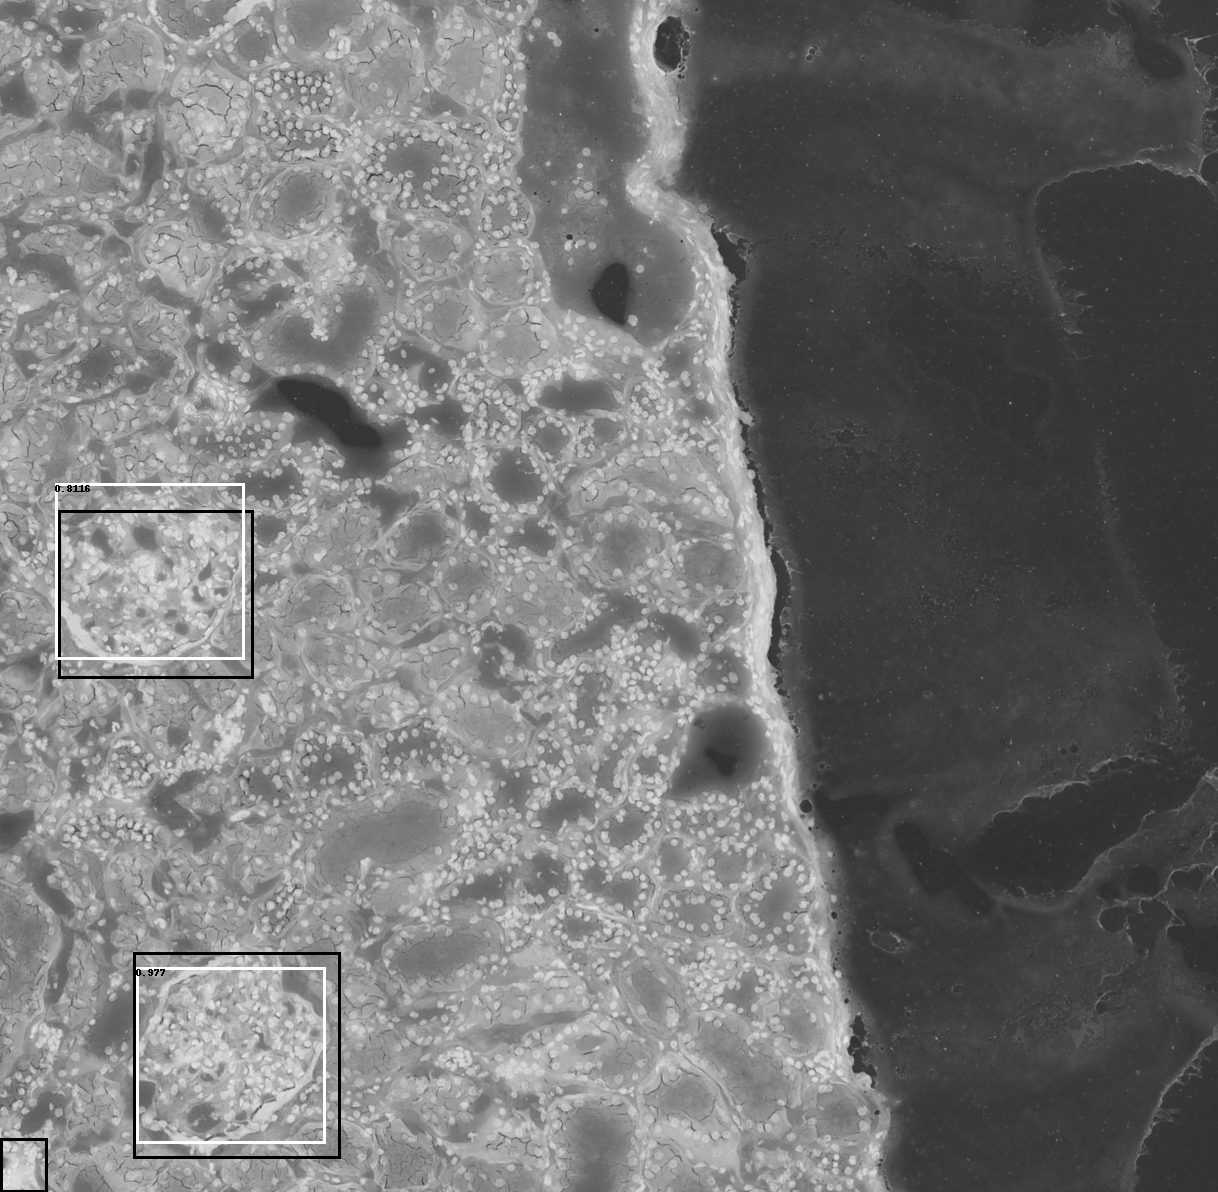

In [11]:
idx = 7
img, _ = dataset_test[idx]
label_boxes = np.array(dataset_test[idx][1]["boxes"])

# put the model in evaluation mode
loaded_model.eval()
with torch.no_grad():
    prediction = loaded_model([img])

# turn the test images from tensor arrays to PIL image
x = img*255
image = ToPILImage()(x) 

# draw the boxes around the predicted glomeruli, return the image
draw = ImageDraw.Draw(image)
for elem in range(len(label_boxes)):
    draw.rectangle([(label_boxes[elem][0], label_boxes[elem][1]),
    (label_boxes[elem][2], label_boxes[elem][3])], 
    outline ="black", width =3)

for element in range(len(prediction[0]["boxes"])):
    boxes = prediction[0]["boxes"][element].cpu().numpy()
    score = np.round(prediction[0]["scores"][element].cpu().numpy(),
                    decimals= 4)
    if score > 0.8:
        draw.rectangle([(boxes[0], boxes[1]), (boxes[2], boxes[3])], 
        outline ='white', width =3)
        draw.text((boxes[0], boxes[1]), text = str(score))
image

### Make a test class

In [117]:
class TestingDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        self.imgs = sorted(os.listdir(os.path.join(root, 'test/slices')))
    def __getitem__(self, idx):
        # load images and bounding boxes
        img_path = os.path.join(self.root,'test/slices', self.imgs[idx])
        img = tiff.imread(img_path)
        if len(img.shape) == 5:
            img = img.squeeze().transpose(1, 2, 0)
        
        # there is only one class
        image_id = torch.tensor([idx])
        imgid = self.imgs[idx]
        target = {}
        if self.transforms is not None:
            img = self.transforms(img, target)
        return img, imgid
    def __len__(self):
        return len(self.imgs)

In [135]:
testset = TestingDataset(root = r'C:\Users\lettuces\Documents\Projects\hubmap-kidney-segmentation', 
                         transforms = get_transform(train=False))
testset.__getitem__(0)

((tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.8353, 0.8353, 0.8353],
           [0.0000, 0.0000, 0.0000,  ..., 0.8353, 0.8353, 0.8353],
           [0.0000, 0.0000, 0.0000,  ..., 0.8353, 0.8353, 0.8353],
           ...,
           [0.0000, 0.0000, 0.0000,  ..., 0.8353, 0.8353, 0.8392],
           [0.0000, 0.0000, 0.0000,  ..., 0.8353, 0.8353, 0.8392],
           [0.0000, 0.0000, 0.0000,  ..., 0.8392, 0.8353, 0.8353]]]),
  {}),
 '26dc41664_0_0.tiff')

### Use model on Test images

In [15]:
loaded_model = get_model(num_classes = 2)
loaded_model.load_state_dict(torch.load("../train/model/model"))

<All keys matched successfully>

In [43]:
%%time
if torch.cuda.is_available():
    loaded_model.cuda()

loaded_model.eval()

prediction = []
for i in range(len(testset)):
    tensor_img = testset[i][0][None, :,:].to(device)
    
    with torch.no_grad():
        preds = loaded_model(tensor_img)
        prediction.append(preds[0].cpu().numpy())

Wall time: 10min 22s


### Save the list of predictions as a dataframe

In [130]:
test_preds = pd.DataFrame(prediction)

In [131]:
test_preds['filename'] = testset.imgs

In [133]:
test_preds.to_csv('../CSVs/test_preds.csv', index=False)

### Visualize predictions

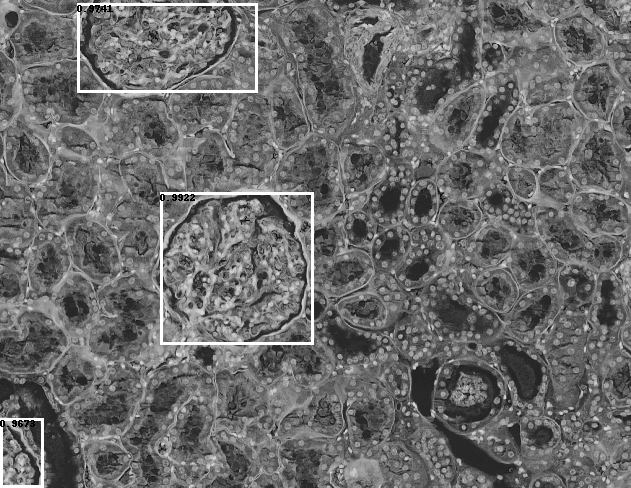

In [174]:
idx = 2635

img, _ = testset[idx][0]

# turn the test images from tensor arrays to PIL image
x = img*255
image = ToPILImage()(x) 

# draw the boxes around the predicted glomeruli, return the image
draw = ImageDraw.Draw(image)

for ele in range(len(test_preds.loc[idx]['boxes'])):
    boxes = prediction[idx]['boxes'][ele].cpu().numpy()
    score = np.round(prediction[idx]["scores"][ele].cpu().numpy(),
                    decimals= 4)
    if score > 0.91:
        draw.rectangle([(boxes[0], boxes[1]), (boxes[2], boxes[3])], 
        outline ='white', width =3)
        draw.text((boxes[0], boxes[1]), text = str(score))
image